<a href="https://colab.research.google.com/github/Mattlee10/zone2/blob/main/25_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 수집

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_health_export(xml_path, record_types=None):
    """
    Apple Health Export XML에서 원하는 Record Type만 추출
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    records = []

    for rec in root.findall('Record'):
        rtype = rec.get('type')
        if record_types and rtype not in record_types:
            continue
        val = rec.get('value')
        if val is None:
            continue
        records.append({
            'type': rtype,
            'value': float(val),
            'unit': rec.get('unit'),
            'start': pd.to_datetime(rec.get('startDate')),
            'end': pd.to_datetime(rec.get('endDate'))
        })

    return pd.DataFrame(records)

# XML 경로 설정 (Google Drive에서 마운트한 경로 또는 Colab 업로드 경로)
xml_path = '/content/drive/MyDrive/Export_ds.xml'

# 필요 Record Type 정의
record_types = [
    'HKQuantityTypeIdentifierHeartRate',
    'HKQuantityTypeIdentifierRestingHeartRate',
    'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'
]

# 파싱 실행
df = parse_health_export(xml_path, record_types=record_types)

# 결과 미리보기
print(df.head())

                                type    value       unit  \
0  HKQuantityTypeIdentifierHeartRate  66.0000  count/min   
1  HKQuantityTypeIdentifierHeartRate  77.0000  count/min   
2  HKQuantityTypeIdentifierHeartRate  71.9442  count/min   
3  HKQuantityTypeIdentifierHeartRate  70.0000  count/min   
4  HKQuantityTypeIdentifierHeartRate  75.0000  count/min   

                      start                       end  
0 2021-06-24 22:43:39+09:00 2021-06-24 22:43:39+09:00  
1 2021-06-24 22:44:53+09:00 2021-06-24 22:44:53+09:00  
2 2021-06-24 22:49:47+09:00 2021-06-24 22:49:47+09:00  
3 2021-06-24 22:50:54+09:00 2021-06-24 22:50:54+09:00  
4 2021-06-24 23:00:35+09:00 2021-06-24 23:00:35+09:00  


# 데이터 전처리

- 사용자 정보 입력 및 RHR 추정

In [2]:
# 사용자 정보
age = 31  # 사용자 나이에 맞게 수정
mhr = 220 - age  # 최대 심박수

# 안정심박수 평균 계산
rhr_df = df[df['type'] == 'HKQuantityTypeIdentifierRestingHeartRate']
rhr = rhr_df['value'].mean()
print(f"평균 안정심박수 (RHR): {rhr:.2f} bpm")

평균 안정심박수 (RHR): 62.70 bpm


- 실시간 HR 데이터 필터링

In [3]:
# 실시간 심박수만 필터링
hr_df = df[df['type'] == 'HKQuantityTypeIdentifierHeartRate'].copy()

# 확인
print(f"심박수 데이터 개수: {len(hr_df)}")
print(hr_df.head())

심박수 데이터 개수: 367494
                                type    value       unit  \
0  HKQuantityTypeIdentifierHeartRate  66.0000  count/min   
1  HKQuantityTypeIdentifierHeartRate  77.0000  count/min   
2  HKQuantityTypeIdentifierHeartRate  71.9442  count/min   
3  HKQuantityTypeIdentifierHeartRate  70.0000  count/min   
4  HKQuantityTypeIdentifierHeartRate  75.0000  count/min   

                      start                       end  
0 2021-06-24 22:43:39+09:00 2021-06-24 22:43:39+09:00  
1 2021-06-24 22:44:53+09:00 2021-06-24 22:44:53+09:00  
2 2021-06-24 22:49:47+09:00 2021-06-24 22:49:47+09:00  
3 2021-06-24 22:50:54+09:00 2021-06-24 22:50:54+09:00  
4 2021-06-24 23:00:35+09:00 2021-06-24 23:00:35+09:00  


- Karvonen 기반 운동강도 비율(%) 계산

In [4]:
# 운동강도 비율(%) 계산
hr_df['intensity_pct'] = ((hr_df['value'] - rhr) / (mhr - rhr)) * 100

# 0~100%로 범위 제한
hr_df['intensity_pct'] = hr_df['intensity_pct'].clip(lower=0, upper=100)

# 샘플 확인
print(hr_df[['start', 'value', 'intensity_pct']].head())

                      start    value  intensity_pct
0 2021-06-24 22:43:39+09:00  66.0000       2.611156
1 2021-06-24 22:44:53+09:00  77.0000      11.320728
2 2021-06-24 22:49:47+09:00  71.9442       7.317650
3 2021-06-24 22:50:54+09:00  70.0000       5.778273
4 2021-06-24 23:00:35+09:00  75.0000       9.737169


- 10% 단위 구간 분류 및 머문 시간 비율 계산

In [5]:
# 구간 정의
import numpy as np
bins = np.arange(0, 110, 10)
labels = [f"{i}~{i+10}%" for i in bins[:-1]]

# 구간별 분류
hr_df['zone'] = pd.cut(hr_df['intensity_pct'], bins=bins, labels=labels, include_lowest=True)

# 구간별 머문 비율 계산 (%)
zone_pct = hr_df['zone'].value_counts(normalize=True).sort_index() * 100
print(zone_pct)

zone
0~10%      24.242028
10~20%     21.972059
20~30%     19.634606
30~40%     17.295520
40~50%      9.338112
50~60%      4.732594
60~70%      1.913501
70~80%      0.699875
80~90%      0.154832
90~100%     0.016871
Name: proportion, dtype: float64


# 시각화

- 날짜 필터링(5월 18일 - 5월 24일)

In [7]:
import pytz

# 한국 시간대 객체 생성
korea_tz = pytz.timezone("Asia/Seoul")

# tz-aware datetime으로 변환
start_date = pd.Timestamp("2025-05-18", tz=korea_tz)
end_date = pd.Timestamp("2025-05-24 23:59:59", tz=korea_tz)

# 필터링
hr_filtered = hr_df[(hr_df['start'] >= start_date) & (hr_df['start'] <= end_date)]

- 필터된 데이터로 구간별 비율 재계산

In [8]:
# 구간별 비율 재계산 (필터된 데이터 기반)
zone_pct_filtered = hr_filtered['zone'].value_counts(normalize=True).sort_index() * 100
print(zone_pct_filtered)

zone
0~10%       7.121623
10~20%     11.063720
20~30%     21.364870
30~40%     24.440998
40~50%     18.133644
50~60%     11.309293
60~70%      5.144113
70~80%      1.331265
80~90%      0.090474
90~100%     0.000000
Name: proportion, dtype: float64


- 시각화

<ipython-input-9-6c2225420f79>:10: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-6c2225420f79>:10: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-6c2225420f79>:10: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-6c2225420f79>:10: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-6c2225420f79>:10: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-6c2225420f79>:10: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-6c2225420f79>:10: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-

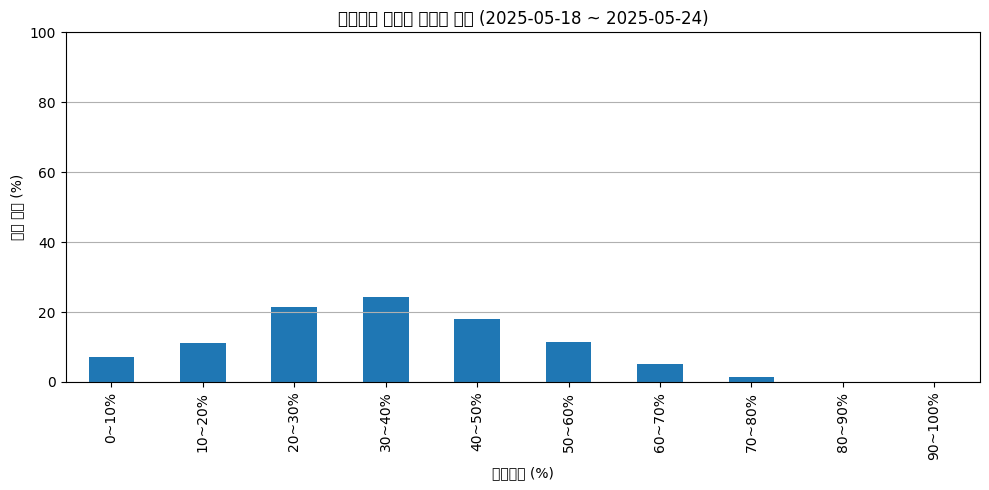

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
zone_pct_filtered.plot(kind='bar')
plt.title('운동강도 구간별 머무른 비율 (2025-05-18 ~ 2025-05-24)')
plt.xlabel('운동강도 (%)')
plt.ylabel('시간 비율 (%)')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()